In [1]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import KDTree
import seaborn as sns
from astrodendro import Dendrogram
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from aRead import readAREPO, readImage
from peakFilteringFunctions import allFilters
import constants as c

### Peak Identification

In [2]:
# Load in the snapshot data
data1 = readAREPO("/scratch/c.c1922522/bigClouds/UV1/cloudUV1_041.hdf5", 1)
data10 = readAREPO("/scratch/c.c1922522/bigClouds/UV10/cloudUV10_042.hdf5", 1)
data100 = readAREPO("/scratch/c.c1922522/bigClouds/UV100/cloudUV100_077.hdf5", 1)
data1000 = readAREPO("/scratch/c.c1922522/bigClouds/UV1000/cloudUV1000_072.hdf5", 1)

In [3]:
# Function to get the distances between peaks that we identify
def getPeakDistances(data):
    # Find the peaks
    peaks = np.where(data.maxPotential == 1)[0]
    passTests, jL = allFilters(data, jeansOnly=True)
    truePeaks = np.where(passTests == 1)
    peaks = peaks[truePeaks]

    # Extract peak positions
    x = data.x[peaks]
    y = data.y[peaks]
    z = data.z[peaks]

    # Create a KDTree with the peak data
    positions = np.array([x, y, z]).T
    tree = KDTree(positions)

    # Find nearest neighbours for all the peaks
    nearest = tree.query(positions, 2)
    neighbours = nearest[0][:,1]

    return neighbours, jL, truePeaks

In [4]:
# Get the distances between the peaks and the peak IDs
n1, j1, p1 = getPeakDistances(data1)
n10, j10, p10 = getPeakDistances(data10)
n100, j100, p100 = getPeakDistances(data100)
n1000, j1000, p1000 = getPeakDistances(data1000)

Text(0.5, 0, '$\\rm \\gamma_{SFR}$')

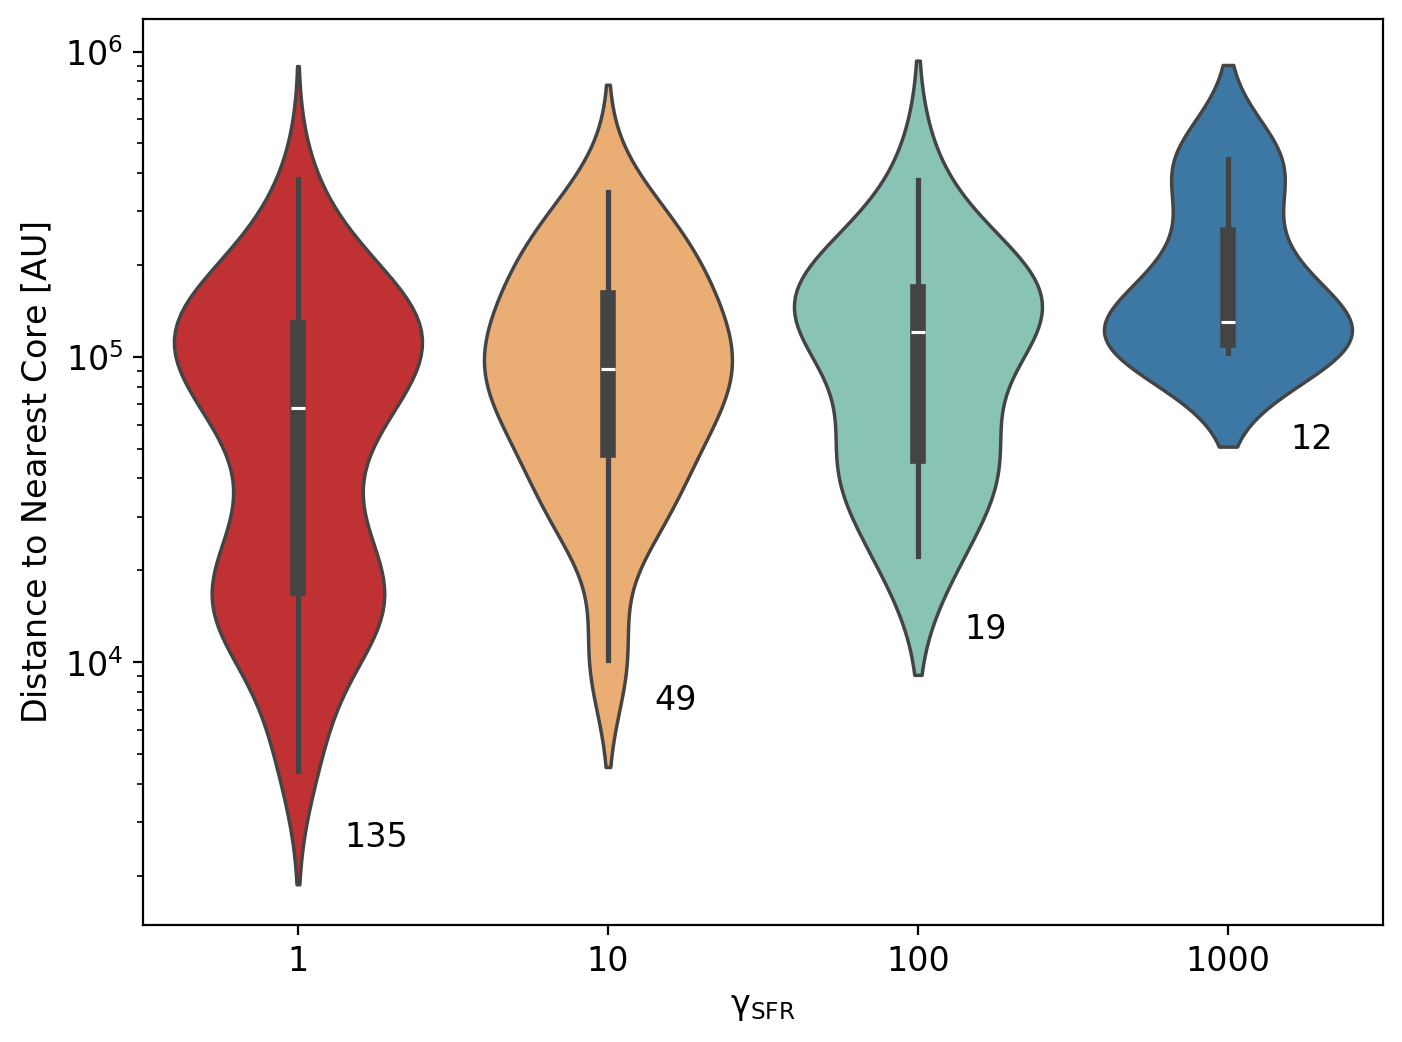

In [6]:
# Create the figure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['figure.dpi'] = 200

# Create dictionary containing the data
data = {
    "1": n1/1.5e13,
    "10": n10/1.5e13,
    "100": n100/1.5e13,
    "1000": n1000/1.5e13,
}

colors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]

# Plot the data and format
sns.violinplot(data, log_scale=True, palette=colors)

# Add the number of peaks 
plt.text(0.15, 2.5e3, len(n1))
plt.text(1.15, 7e3,len(n10))
plt.text(2.15, 1.2e4, len(n100))
plt.text(3.2, 5e4, len(n1000))

plt.ylabel("Distance to Nearest Core [$\\rm AU$]")
plt.xlabel("$\\rm \gamma_{SFR}$")

In [12]:
# Make plot for the whole set of voronoi neighbours peaks
fileNames = ['voronoi_neighbours_041.', 'voronoi_neighbours_042.', 'voronoi_neighbours_077.', 'voronoi_neighbours_072.']
dataObjects = [data1, data10, data100, data1000]

for i in range(len(fileNames)):
    # Open the file
    with open("/home/c.c1922522/stardustCodes/" + fileNames[i], "rb") as file:
        vNeighbours = pickle.load(file)

    # Find the true peaks   
    data = dataObjects[i]
    data.maxPotential[:] = 0
    data.potential = abs(data.potential)

    for n in tqdm(range(data.nParticles)):
        # Check if its the maximum peak of neighbours
        neigh = list(vNeighbours[n])

        if data.potential[neigh].max() < data.potential[n]:
            data.maxPotential[n] = 1

    # Re-Assign the data object
    dataObjects[i] = data

100%|██████████| 1288303/1288303 [00:15<00:00, 84005.16it/s]


In [13]:
# Get the distances between the peaks and the peak IDs
n1, j1, p1 = getPeakDistances(dataObjects[0])
n10, j10, p10 = getPeakDistances(dataObjects[1])
n100, j100, p100 = getPeakDistances(dataObjects[2])
n1000, j1000, p1000 = getPeakDistances(dataObjects[3])

Text(0.5, 0, '$\\rm \\gamma_{SFR}$')

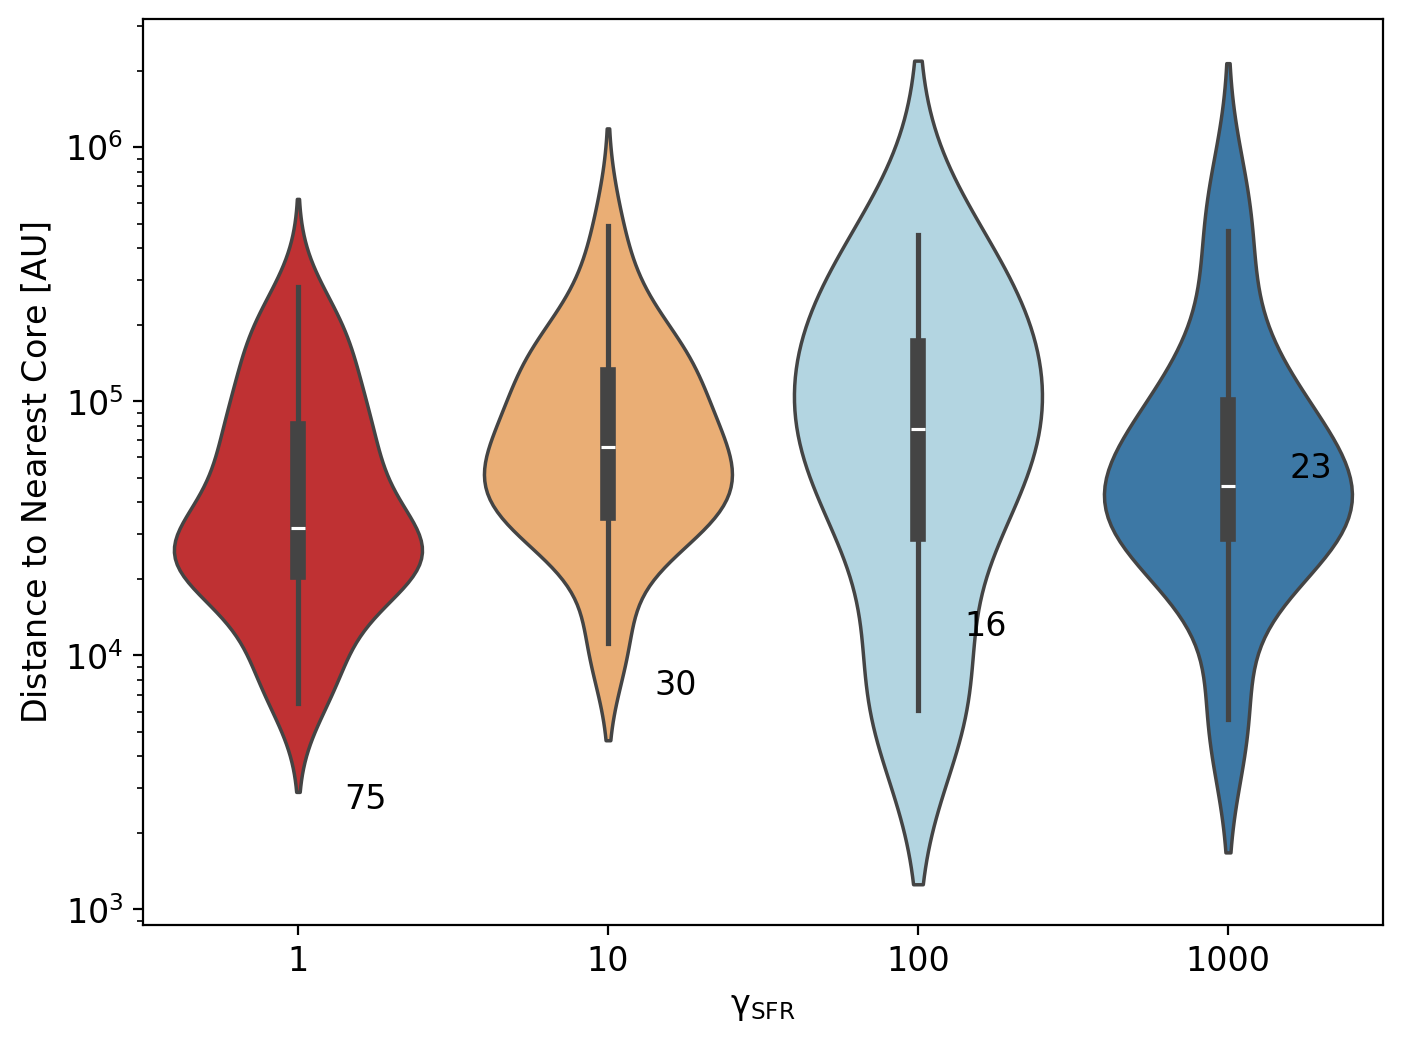

In [14]:
# Create the figure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['figure.dpi'] = 200

# Create dictionary containing the data
data = {
    "1": n1/1.5e13,
    "10": n10/1.5e13,
    "100": n100/1.5e13,
    "1000": n1000/1.5e13,
}

colors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]

# Plot the data and format
sns.violinplot(data, log_scale=True, palette=colors)

# Add the number of peaks 
plt.text(0.15, 2.5e3, len(n1))
plt.text(1.15, 7e3,len(n10))
plt.text(2.15, 1.2e4, len(n100))
plt.text(3.2, 5e4, len(n1000))

plt.ylabel("Distance to Nearest Core [$\\rm AU$]")
plt.xlabel("$\\rm \gamma_{SFR}$")

### Core Mass Function

In [3]:
def coreMassFunction(imagePath, minVal=22.3, minPix=10, minDelta=0.09):
    # Load in the image data
    image = readImage(imagePath)

    # Create the grid and column density map
    columnGrid = image.image * image.umass_g / (1.4*c.mProt()*image.ulength_cm**2)

    # Find the pixel size
    #pixSize = (image.x1-image.x0) * (image.y1-image.y0) * image.ulength_cm**2 / (image.nx*image.ny)
    pixSize = 2.4414062499999997e+32

    # Create the dendrogram
    dendro = Dendrogram.compute(np.log10(columnGrid), min_value=minVal, min_npix=minPix, min_delta=minDelta)

    # Calculate the CMF 
    masses = np.zeros(len(dendro.leaves))
    for i in range(len(dendro.leaves)):
        pixVals = 10**dendro.leaves[i].values() * 1.4 * c.mProt() * pixSize

        masses[i] = np.sum(pixVals) / c.uMass()
        
    print("Done")

    return masses

In [4]:
m1 = coreMassFunction("/home/c.c1922522/apricot/CMFimages3/column_cloudUV1_041.dat")
m2 = coreMassFunction("/home/c.c1922522/apricot/CMFimages3/column_cloudUV10_042.dat")
m3 = coreMassFunction("/home/c.c1922522/apricot/CMFimages3/column_cloudUV100_077.dat")
m4 = coreMassFunction("/home/c.c1922522/apricot/CMFimages3/column_cloudUV1000_072.dat")

m1cr = coreMassFunction("/scratch/c.c1922522/bigClouds/UV1crAtt/column_cloudUV1_040.dat")
m1000cr = coreMassFunction("/scratch/c.c1922522/bigClouds/UV1000crAtt/column_cloudUV1000_065.dat")

Done
Done
Done
Done
Done
Done


#### Cumulative Core Mass Function

Text(0, 0.5, 'Cumulative Fraction')

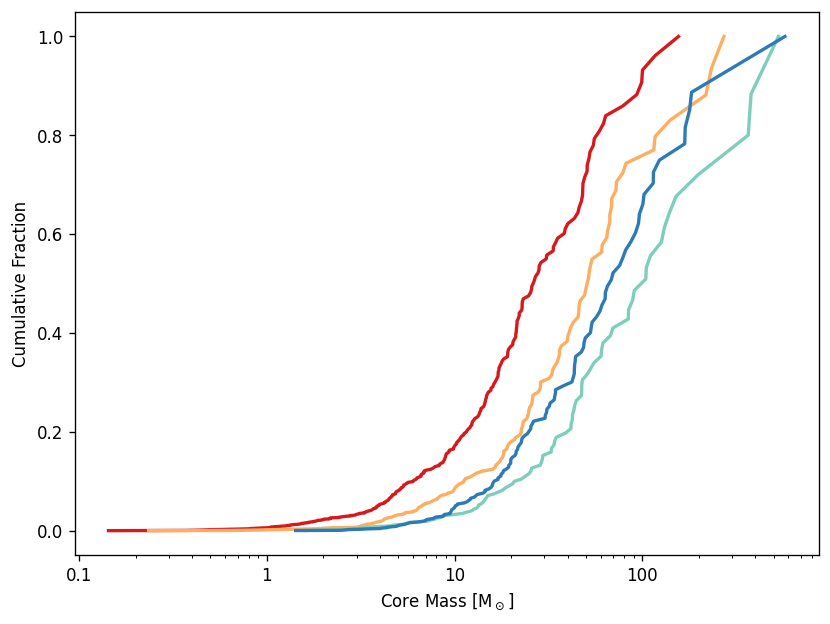

In [7]:
m1s = np.sort(m1)
m1c = np.cumsum(m1s)
m2s = np.sort(m2)
m2c = np.cumsum(m2s)
m3s = np.sort(m3)
m3c = np.cumsum(m3s)
m4s = np.sort(m4)
m4c = np.cumsum(m4s)

plt.figure(figsize=(8,6))
plt.rcParams["figure.dpi"] = 120
plt.plot(m1s, m1c/m1c[-1], c.colours()[0], linewidth=2)
plt.plot(m2s, m2c/m2c[-1], c.colours()[1], linewidth=2)
plt.plot(m3s, m3c/m3c[-1], c.colours()[3], linewidth=2)
plt.plot(m4s, m4c/m4c[-1], c.colours()[4], linewidth=2)

totMasses = [m1, m2, m3, m4]

plt.xscale("log")
plt.xticks([0.1, 1, 10, 100], ["0.1", "1", "10", "100"])
plt.xlabel("Core Mass [$\\rm M_\odot$]")
plt.ylabel("Cumulative Fraction")

In [10]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**(-b)

#### Raw Core Mass Function

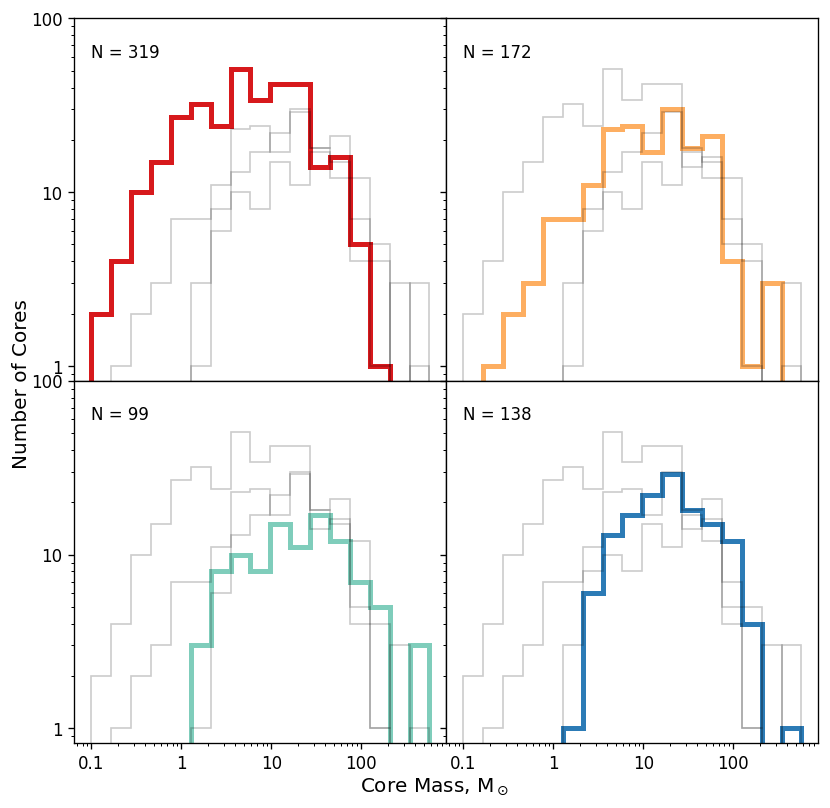

In [9]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

fig.supxlabel("Core Mass, $\\rm M_\odot$", y=0.07)
fig.supylabel("Number of Cores", x=0.06)

# Setup parameters
colors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]
x = np.linspace(0, 2.2, 100)
bins = 10**np.linspace(-1, np.max(np.log10(totMasses[-1])), 18)

xs = [0,0,1,1]
ys = [0, 1, 0, 1]

for i in range(4):
    thisPlot = totMasses[i]
    notThisPlot = totMasses[:i] + totMasses[i+1:]

    ax = axs[xs[i], ys[i]]

    hist = ax.hist(thisPlot, bins=bins, histtype="step", color=colors[i], linestyle="-", label="UV1", linewidth=3)
    hist = ax.hist(notThisPlot,  bins=bins, histtype="step", color=["k", "k", "k"], linestyle="-", alpha=0.2)
    
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xticks([0.1, 1, 10, 100], ["0.1", "1", "10", "100"])
    
    if i == 1 or i == 3:
        ax.set_yticks([1, 10, 100])
        ax.set_yticklabels([])
    else:
        ax.set_yticks([1, 10, 100])
        ax.set_yticklabels(["1", "10", "100"])

    ax.text(0.1,60, "N = %s" % len(thisPlot))


#### Raw and Cumulative Core Mass Function

Text(0.08, 0.5, 'Number of Cores')

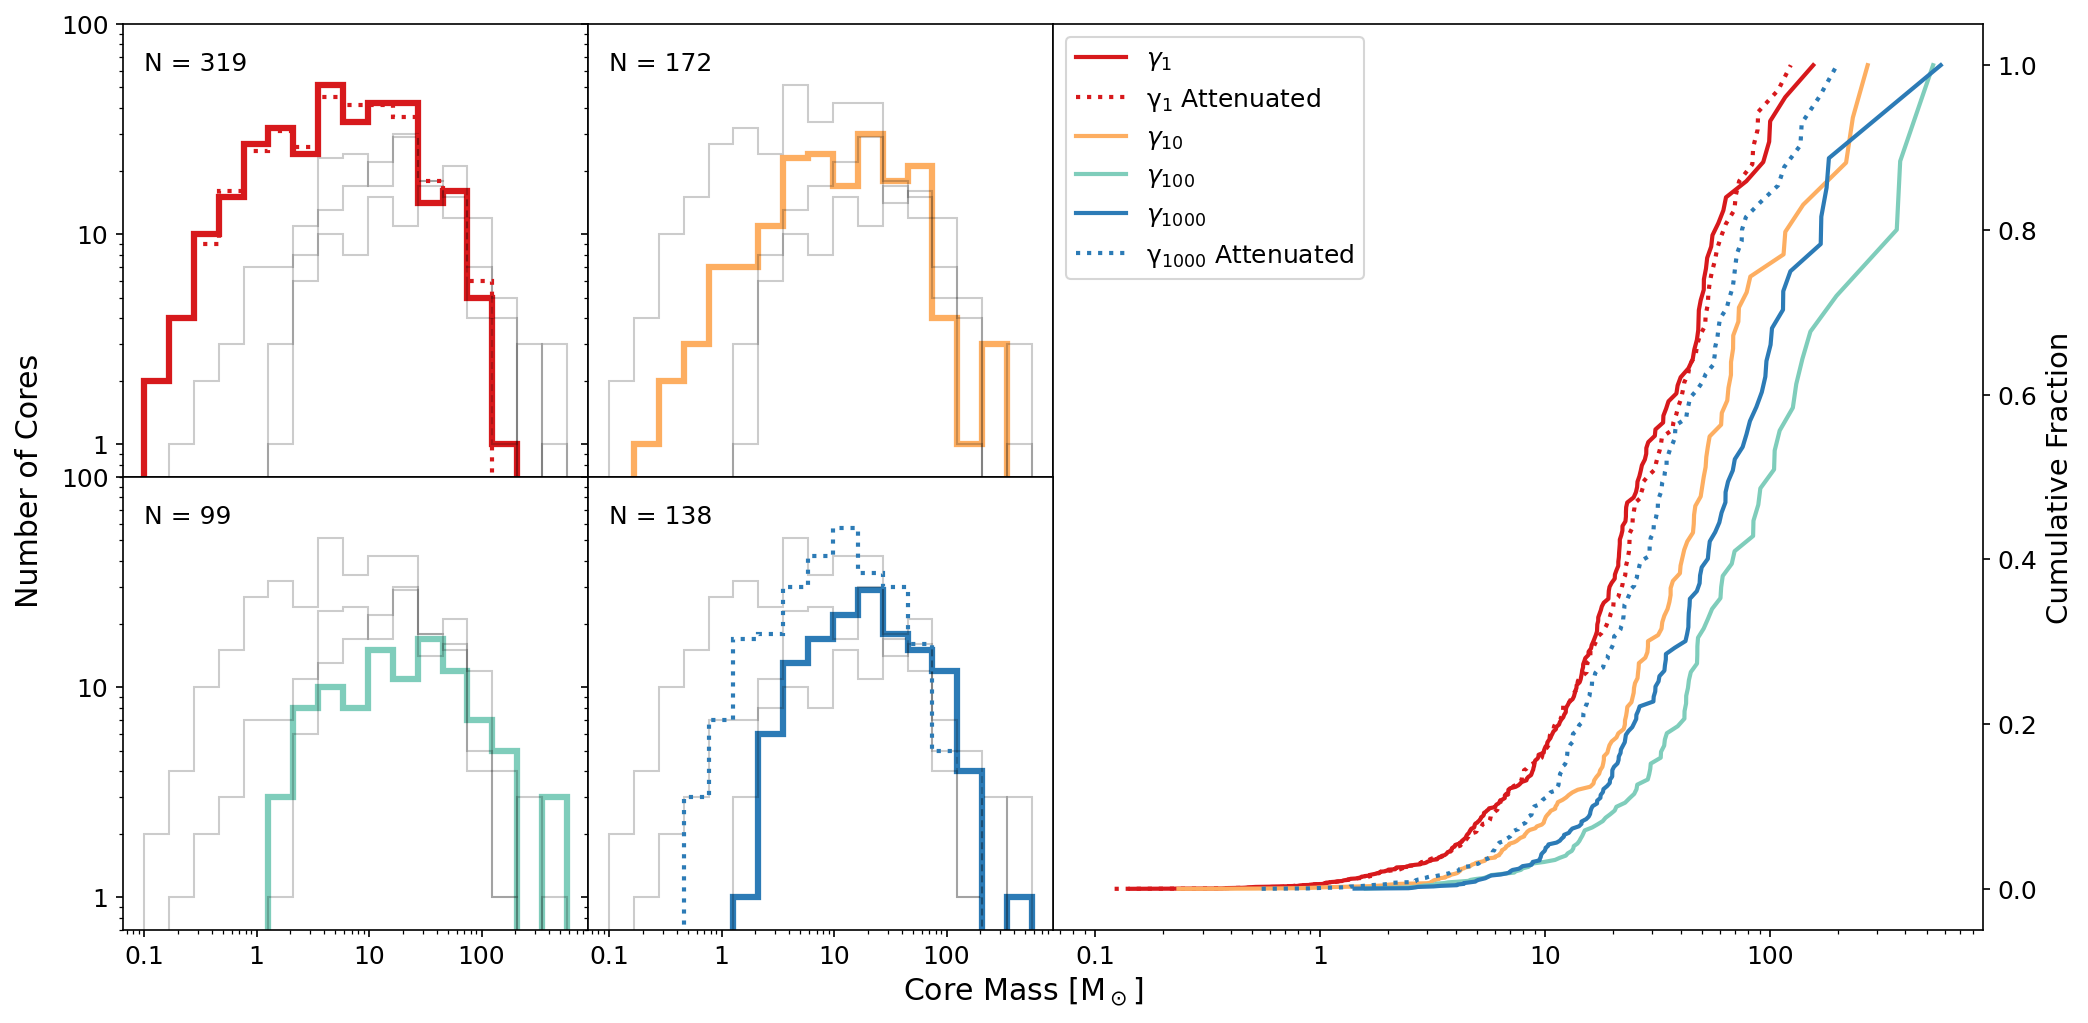

In [19]:
plt.style.use("mattStyle")

# Setup the figure and adjust
fig, axs = plt.subplot_mosaic([['upper left', 'upper center', 'right', 'right'],
                               ['lower left', 'lower center', 'right', 'right']],
                              figsize=(16, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

axes = ["upper left", "upper center", "lower left", "lower center"]
labels = ["$\\gamma_1$", "$\\gamma_{10}$", "$\\gamma_{100}$", "$\\gamma_{1000}$"]
bins = 10**np.linspace(-1, np.max(np.log10(totMasses[-1])), 18)
x = np.linspace(0.7, np.max(np.log10(bins)), 100)

# Plot the normal CMFs
for i in range(4):
    thisPlot = totMasses[i]
    notThisPlot = totMasses[:i] + totMasses[i+1:]

    hist = axs[axes[i]].hist(thisPlot, bins=bins, histtype="step", color=colors[i], linestyle="-", label="UV1", linewidth=3)
    hist = axs[axes[i]].hist(notThisPlot,  bins=bins, histtype="step", color=["k", "k", "k"], linestyle="-", alpha=0.2)
    #axs[axes[i]].plot(10**x, 300*(10**x)**(-1.35), "k", linestyle="--", linewidth=2)
    
    if i == 0:
        hist = axs[axes[i]].hist(m1cr, bins=bins, histtype="step", color=colors[i], linestyle=":", linewidth=2)
    elif i == 3:
        hist = axs[axes[i]].hist(m1000cr, bins=bins, histtype="step", color=colors[i], linestyle=":", linewidth=2)

    axs[axes[i]].set_xscale("log")
    axs[axes[i]].set_yscale("log")

    axs[axes[i]].set_xticks([0.1, 1, 10, 100])
    axs[axes[i]].set_xticklabels(["0.1", "1", "10", "100"])

    if i == 1 or i == 3:
        axs[axes[i]].set_yticks([1, 10, 100])
        axs[axes[i]].set_yticklabels([])
    else:
        axs[axes[i]].set_yticks([1, 10, 100])
        axs[axes[i]].set_yticklabels(["1", "10", "100"])

    axs[axes[i]].text(0.1,60, "N = %s" % len(thisPlot))
    axs[axes[i]].set_ylim(0.7, 100)

for i in range(4):
    mSort = np.sort(totMasses[i])
    mCum = np.cumsum(mSort)

    # Plot the data
    axs["right"].plot(mSort, mCum/mCum[-1], color=colors[i], linewidth=2, label=labels[i])
    
    if i == 0:
        mSort = np.sort(m1cr)
        axs["right"].plot(mSort, np.cumsum(mSort)/np.cumsum(mSort)[-1], color=colors[i], linewidth=2, linestyle=":", label="$\\rm \\gamma_1$ Attenuated")
    elif i == 3:
        mSort = np.sort(m1000cr)
        axs["right"].plot(mSort, np.cumsum(mSort)/np.cumsum(mSort)[-1], color=colors[i], linewidth=2, linestyle=":", label="$\\rm \\gamma_{1000}$ Attenuated")
    
    axs["right"].yaxis.tick_right()
    axs["right"].set_ylabel("Cumulative Fraction", fontsize=14)
    axs["right"].yaxis.set_label_position("right")

axs["right"].legend()

fig.supxlabel("Core Mass $\\rm [M_\odot]$", y=0.06)
fig.supylabel("Number of Cores", x=0.08)

### Dendrogram Parameter Variation

Text(0.05, 0.5, 'Cumulative Fraction')

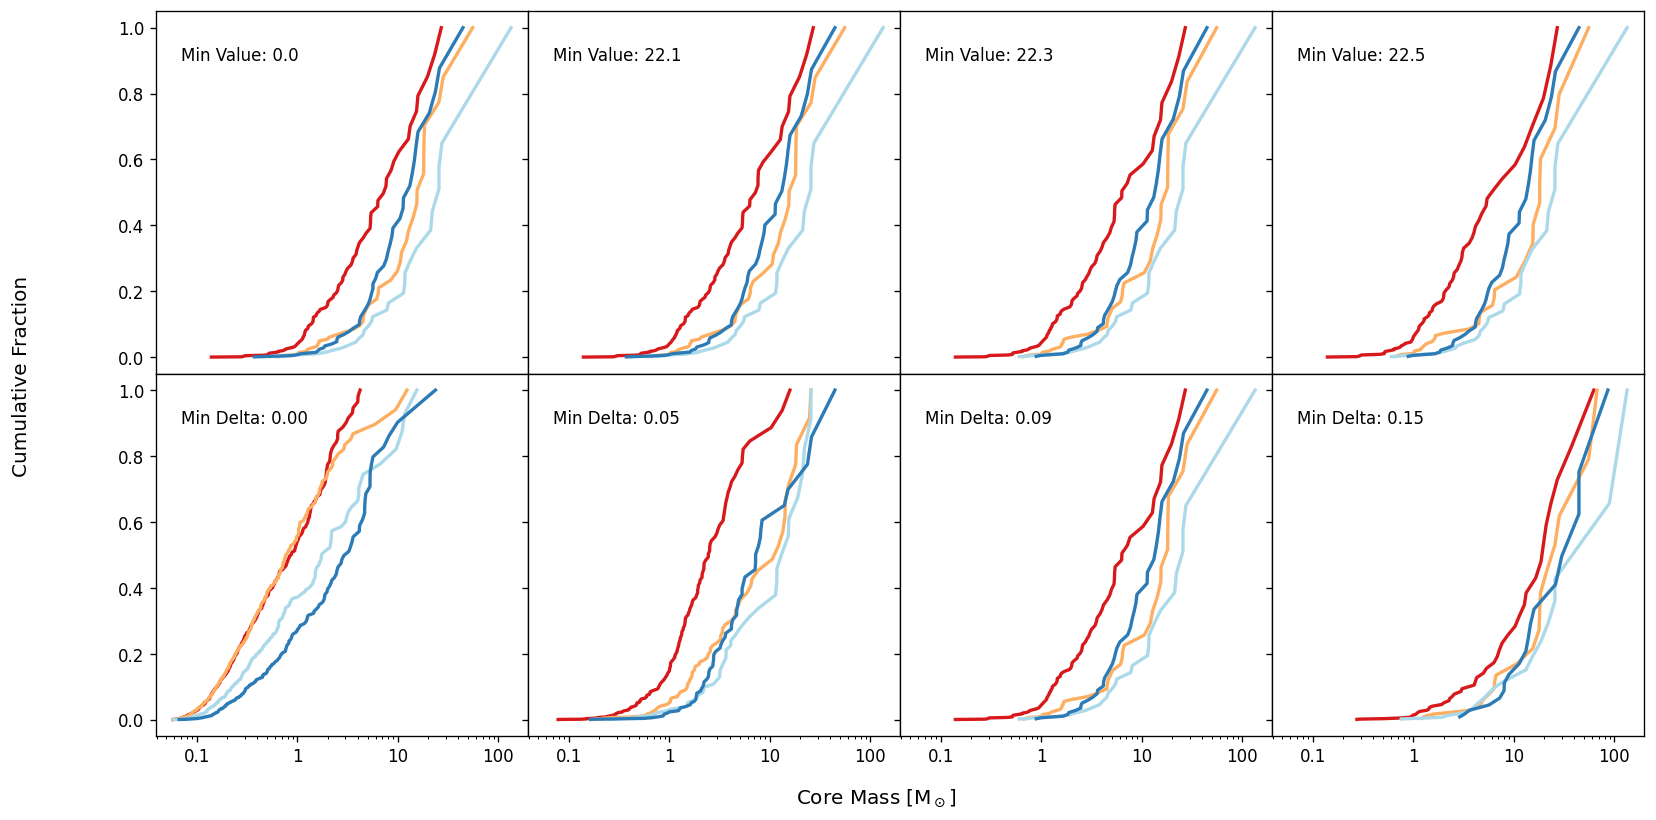

In [28]:
minVals = [0, 22.1, 22.3, 22.5]
minDeltas = [0, 0.05, 0.09, 0.15]

# Create figure 
fig, axs = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Loop through min values
for i in range(len(minVals)):
    m1 = loopThroughImages(1, 1, "/home/c.c1922522/apricot/CMFimages2/", minVal=minVals[i])
    m2 = loopThroughImages(1, 10, "/home/c.c1922522/apricot/CMFimages2/", minVal=minVals[i])
    m3 = loopThroughImages(1, 100, "/home/c.c1922522/apricot/CMFimages2/", minVal=minVals[i])
    m4 = loopThroughImages(1, 1000, "/home/c.c1922522/apricot/CMFimages2/", minVal=minVals[i])

    m1s = np.sort(m1)
    m1c = np.cumsum(m1s)
    m2s = np.sort(m2)
    m2c = np.cumsum(m2s)
    m3s = np.sort(m3)
    m3c = np.cumsum(m3s)
    m4s = np.sort(m4)
    m4c = np.cumsum(m4s)

    axs[0,i].plot(m1s, m1c/m1c[-1], c.colours()[0], linewidth=2)
    axs[0,i].plot(m2s, m2c/m2c[-1], c.colours()[1], linewidth=2)
    axs[0,i].plot(m3s, m3c/m3c[-1], c.colours()[3], linewidth=2)
    axs[0,i].plot(m4s, m4c/m4c[-1], c.colours()[4], linewidth=2)

    axs[0,i].text(0.07, 0.9, "Min Value: {:.1f}".format(minVals[i]))

axs[0,0].set_xscale("log")
axs[0,0].set_xticks([0.1, 1, 10, 100])
axs[0,0].set_xticklabels(["0.1", "1", "10", "100"])

# Loop through min values
for i in range(len(minVals)):
    m1 = loopThroughImages(1, 1, "/home/c.c1922522/apricot/CMFimages2/", minDelta=minDeltas[i])
    m2 = loopThroughImages(1, 10, "/home/c.c1922522/apricot/CMFimages2/", minDelta=minDeltas[i])
    m3 = loopThroughImages(1, 100, "/home/c.c1922522/apricot/CMFimages2/", minDelta=minDeltas[i])
    m4 = loopThroughImages(1, 1000, "/home/c.c1922522/apricot/CMFimages2/", minDelta=minDeltas[i])

    m1s = np.sort(m1)
    m1c = np.cumsum(m1s)
    m2s = np.sort(m2)
    m2c = np.cumsum(m2s)
    m3s = np.sort(m3)
    m3c = np.cumsum(m3s)
    m4s = np.sort(m4)
    m4c = np.cumsum(m4s)

    axs[1,i].plot(m1s, m1c/m1c[-1], c.colours()[0], linewidth=2)
    axs[1,i].plot(m2s, m2c/m2c[-1], c.colours()[1], linewidth=2)
    axs[1,i].plot(m3s, m3c/m3c[-1], c.colours()[3], linewidth=2)
    axs[1,i].plot(m4s, m4c/m4c[-1], c.colours()[4], linewidth=2)

    axs[1,i].text(0.07, 0.9, "Min Delta: {:.2f}".format(minDeltas[i]))

fig.supxlabel("Core Mass [$\\rm M_\\odot$]", y=0.05)
fig.supylabel("Cumulative Fraction", x=0.09)

### Dendrogram Images

In [3]:
# Load in the image files and snapshots
image1 = readImage("/home/c.c1922522/apricot/column_cloudUV1_041.dat")
image10 = readImage("/home/c.c1922522/apricot/column_cloudUV10_042.dat")
image100 = readImage("/home/c.c1922522/apricot/column_cloudUV100_077.dat")
image1000 = readImage("/home/c.c1922522/apricot/column_cloudUV1000_072.dat")

Generating dendrogram using 2,064,065 of 4,194,304 pixels (49.21114444732666% of data)

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                 

KeyboardInterrupt: 

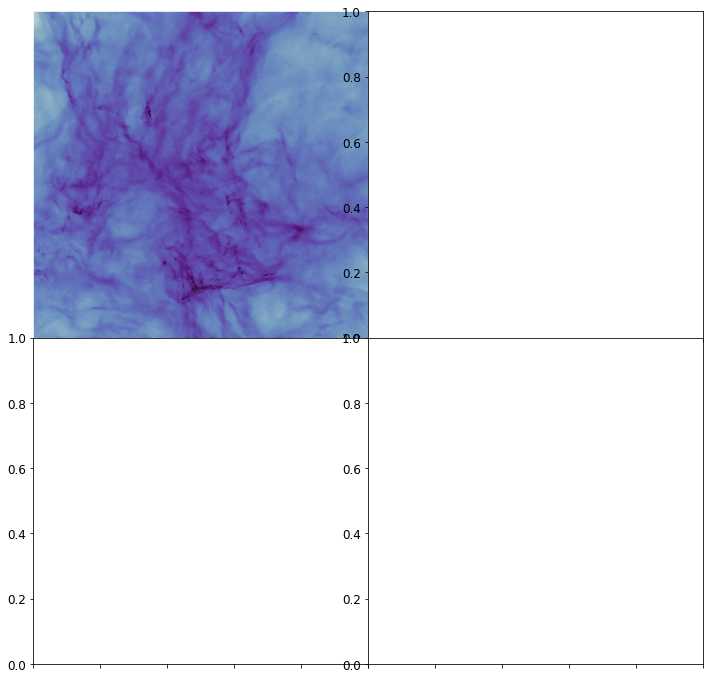

In [5]:
# Create the figure 
fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.subplots_adjust(hspace=0, wspace=0)
matplotlib.rcParams['font.size'] = 12.
matplotlib.rcParams['axes.labelcolor'] = "white"
matplotlib.rcParams['xtick.labelcolor'] = "white"

# Loop through each image and plot
ys = [0, 1, 0, 1]
xs = [0, 0, 1, 1]
images = [image1, image10, image100, image1000]

mincol = 19
lvls = list(np.linspace(mincol+2, mincol+7, 100))

for i in range(4):
    image = images[i]

    # Get limits and max min values
    limits = [image.y0,image.y1,image.x0,image.x1]
    max_image = np.max(image.image)
    min_image = np.min(image.image)

    # Create plotting grid
    xgrid = np.linspace(image.x0,image.x1,image.nx)*image.ulength_cm/c.pc()
    ygrid = np.linspace(image.y0,image.y1,image.ny)*image.ulength_cm/c.pc()
    colgrid = image.image*image.umass_g/(1.4*c.mProt()*image.ulength_cm**2)

    # Do the plotting
    axs[xs[i], ys[i]].set_xticks([])
    axs[xs[i], ys[i]].set_yticks([])
    cs = axs[xs[i], ys[i]].contourf(xgrid,ygrid,np.log10(colgrid+10**mincol),cmap='twilight',levels=lvls)

    plt.setp(axs[xs[i], ys[i]].spines.values(), color="white")

    # Create the dendrogram
    dendro = Dendrogram.compute(np.log10(colgrid), min_value=22.3, min_npix=10, min_delta=0.09, verbose=True)

    # Add the colourbar
    if i == 3:
        cax = axs[xs[i], ys[i]].inset_axes([0.55, 0.15, 0.4, 0.04])
        cbar = fig.colorbar(cs, cax=cax, orientation="horizontal")
        tks = np.linspace(lvls[0],lvls[-1],4)
        cbar.set_ticks([22, 24, 26])
        cbar.set_ticklabels(["$10^{22}$", "$10^{24}$", "$10^{26}$"])
        cbar.set_label("$\\rm N \: [cm^{-2}]$")
        cbar.ax.tick_params(size=0)
        cbar.outline.set_edgecolor("white")

    # Add the scale
    if i == 2:
        asb = AnchoredSizeBar(axs[xs[i], ys[i]].transData, 1, "1 pc", loc="lower left", frameon=False, borderpad=1.5, color="white", sep=6)
        axs[xs[i], ys[i]].add_artist(asb)

In [6]:
# Load in the image data
image = readImage("../apricot/column_cloudUV1000_072.dat")

# Create the grid and column density map
columnGrid = image.image * image.umass_g / (1.4*c.mProt()*image.ulength_cm**2)

# Find the pixel size
#pixSize = (image.x1-image.x0) * (image.y1-image.y0) * image.ulength_cm**2 / (image.nx*image.ny)
pixSize = 2.4414062499999997e+32

# Create the dendrogram
dendro = Dendrogram.compute(np.log10(columnGrid), min_value=22.3, min_npix=10, min_delta=0.09)


/home/c.c1922522/.local/lib/python3.9/site-packages/astrodendro/plot.py:159: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(mask, levels=[0.5], **kwargs)


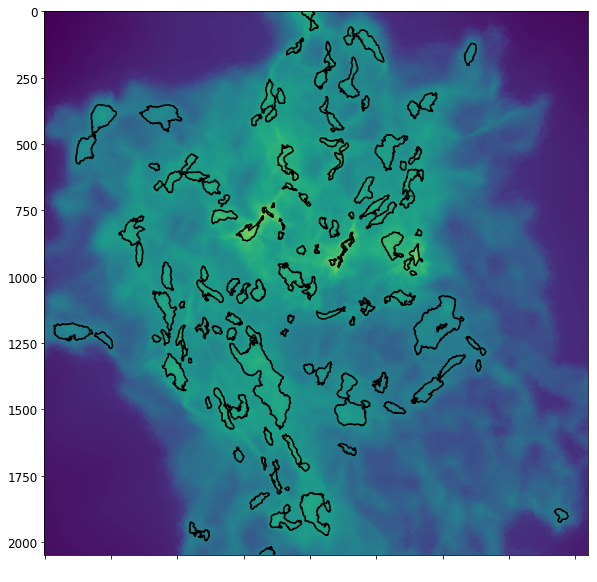

In [29]:


fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.imshow(np.log10(columnGrid + 10**mincol))

p = dendro.plotter()

leaves = dendro.leaves

for leaf in leaves:
    idx = leaf.idx

    p.plot_contour(ax, dendro[idx], color="black")



#ax.contourf(xgrid,ygrid,np.log10(colgrid+10**mincol),cmap='gist_heat',levels=lvls)


In [30]:
# Create the figure 
fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.subplots_adjust(hspace=0, wspace=0)
matplotlib.rcParams['font.size'] = 12.
matplotlib.rcParams['axes.labelcolor'] = "white"
matplotlib.rcParams['xtick.labelcolor'] = "white"

# Loop through each image and plot
ys = [0, 1, 0, 1]
xs = [0, 0, 1, 1]
images = [image1, image10, image100, image1000]
mincol = 19

for i in range(4):
    image = images[i]

    # Get limits and max min values
    limits = [image.y0,image.y1,image.x0,image.x1]
    max_image = np.max(image.image)
    min_image = np.min(image.image)

    # Create plotting grid
    xgrid = np.linspace(image.x0,image.x1,image.nx)*image.ulength_cm/c.pc()
    ygrid = np.linspace(image.y0,image.y1,image.ny)*image.ulength_cm/c.pc()
    colgrid = image.image*image.umass_g/(1.4*c.mProt()*image.ulength_cm**2)

    # Do the plotting
    axs[xs[i], ys[i]].set_xticks([])
    axs[xs[i], ys[i]].set_yticks([])
    cs = axs[xs[i], ys[i]].imshow(np.log10(colgrid+10**mincol))

    plt.setp(axs[xs[i], ys[i]].spines.values(), color="white")

    # Compute the dendrogram
    dendro = Dendrogram.compute(np.log10(colgrid), min_value=22.3, min_npix=10, min_delta=0.09)

    # Plot all the leaves
    p = dendro.plotter()
    leaves = dendro.leaves

    for leaf in leaves:
        idx = leaf.idx

        p.plot_contour(axs[xs[i], ys[i]], dendro[idx], color="black")

    # Add the colourbar
    if i == 3:
        cax = axs[xs[i], ys[i]].inset_axes([0.55, 0.15, 0.4, 0.04])
        cbar = fig.colorbar(cs, cax=cax, orientation="horizontal")
        tks = np.linspace(lvls[0],lvls[-1],4)
        cbar.set_ticks([22, 24, 26])
        cbar.set_ticklabels(["$10^{22}$", "$10^{24}$", "$10^{26}$"])
        cbar.set_label("$\\rm N \: [cm^{-2}]$")
        cbar.ax.tick_params(size=0)
        cbar.outline.set_edgecolor("white")

    # Add the scale
    if i == 2:
        asb = AnchoredSizeBar(axs[xs[i], ys[i]].transData, 1, "1 pc", loc="lower left", frameon=False, borderpad=1.5, color="white", sep=6)
        axs[xs[i], ys[i]].add_artist(asb)

/home/c.c1922522/.local/lib/python3.9/site-packages/astrodendro/plot.py:159: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(mask, levels=[0.5], **kwargs)


: 